In [1]:
!pip install torchmetrics

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os

import cv2
from torchmetrics import F1Score
import pickle

In [3]:
path = '/kaggle/input/traffic-sign-datasets/'
path_dataset1 = path+'Indian Traffic Signs Prediction(85 classes)/Indian Traffic Signs Prediction(85 classes)/'
path_dataset2 = path+'Persian Traffic Sign Dataset (PTSD)/Persian Traffic Sign Dataset (PTSD)/'
path_dataset3 = path+'Traffic Signs (GTSRB plus 162 custom classes)/Traffic Signs (GTSRB plus 162 custom classes)/Data_images/'

savepath='/kaggle/working/'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path='/content/drive/My Drive/6721 Project dataset/'
# savepath = '/content/drive/My Drive/6721 Dataset/'
# print(os.listdir(path))

In [ ]:
# path_dataset1 = path+"Indian Traffic Signs Prediction(85 classes)/"
# path_dataset2 = path+"Persian Traffic Sign Dataset (PTSD)/"
# path_dataset3 = path+"Traffic Signs (GTSRB plus 162 custom classes)/Data_images/"

**Data Loaders**

---



In [5]:
def load_data(path_train, val_split, path_test, batch_size, input_size):
  
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform_train= transforms.Compose([transforms.Resize(input_size),
                                         transforms.ColorJitter(brightness=(0.5,1.2), contrast=0, saturation=0, hue=0),
                                         transforms.RandomHorizontalFlip(),
#                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(45),
                                        transforms.RandomAdjustSharpness(0.8),
                                          transforms.ToTensor(),
                                          normalize
                                          ])

    transform_test = transforms.Compose([transforms.Resize(input_size),
                                         transforms.ToTensor(), 
                                         normalize])

    data_train = datasets.ImageFolder(root=path_train, transform=transform_train)
    data_test = datasets.ImageFolder(root=path_test, transform=transform_test)
    
    mappings = data_train.class_to_idx

    val_size = int(len(data_train)*val_split)
    train_size = len(data_train) - val_size

    train_dataset, val_dataset = td.random_split(data_train, [train_size, val_size])
    
    data_loader_train = td.DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      num_workers=0,       
                                      pin_memory=True)
     
    data_loader_val = td.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=False,
                                    num_workers=0) 
      
    data_loader_test = td.DataLoader(data_test,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=False,
                                   num_workers=0)
    
    return data_loader_train, data_loader_test, data_loader_val, mappings

Compute Class Weights

In [31]:
def get_image_size_dist(path):
    t1 = time.time()

    folders = os.listdir(path)
    total = 0

    class_samples = {}

    for folder in folders:
        samples = os.listdir(path+folder)

        class_samples[folder]=len(samples)

        print("Class: {} has samples: {} ".format(folder,len(samples)))
        total+=len(samples)

    print("\nTotal number of samples: ",total)

    print("\nTime taken: {}".format(time.time()-t1))

    return class_samples, total

In [32]:
def get_class_weights(path_train, mappings):

    class_samples, total = get_image_size_dist(path_train)

    class_weights = [0]*len(mappings.keys())

    for key in mappings.keys():
        class_weights[mappings[key]] = 1 - (class_samples[key]/ total)
      
    return class_weights

Training Setup

---



In [18]:
learning_rate = 0.001
num_epochs = 10

def get_criterion(class_weights):

    criterion = nn.CrossEntropyLoss(weight = class_weights)

    return criterion

In [19]:
def train_model(model, num_epochs, train_loader, criterion, optimizer, savepath, savepath_results, device):

      total_steps = len(train_loader)

      t1 = time.time()

      train_loss=[]
      train_accuracy=[]
      val_accuracy=[]

      for epoch in range(num_epochs):
          for i, data in enumerate(train_loader):
              
              images, labels = data[0].to(device), data[1].to(device)
              
              model.train()

              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # Train accuracy
              total = labels.size(0)
              _, predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              
              if (i + 1) % 10 == 0:
                  model.eval() 
                  with torch.no_grad(): 
                      correctv = 0
                      totalv = 0
                      for datav in val_loader:
                          imagesv, labelsv = datav[0].to(device), datav[1].to(device)
                          outputsv = model(imagesv)
                          _, predictedv = torch.max(outputsv.data, 1)
                          totalv += labelsv.size(0)
                          correctv += (predictedv == labelsv).sum().item()
                          
                      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                          (correct / total) * 100,
                          (correctv / totalv) * 100))
                      
                      train_loss.append(loss.item())
                      train_accuracy.append((correct / total) * 100)
                      val_accuracy.append((correctv / totalv) * 100)
                      
                  
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

      print("/n/n Saving model at: ",savepath)
      torch.save(model.state_dict(), savepath)

      results = { "training_loss": train_loss, "accuracy": train_accuracy, "val_accuracy": val_accuracy }

      with open(savepath_results, "wb") as fp:
          pickle.dump(results, fp)

      return model, device

In [20]:
def evaluate_model(model, test_loader, device,nclasses):
   
    model.eval() 

    Y=[]
    y=[]

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            Y.extend(labels)
            y.extend(predicted)

        acc = (correct / total) * 100
        f1 = F1Score(num_classes=nclasses)
        f1score = f1(torch.IntTensor(y),torch.IntTensor(Y))

        print('Model Evaluation Results on {} test samples'.format(total))
        print('Test Accuracy: ', acc)
        print('Test F1 Score: ',f1score)
        

Architecture 1: AlexNet

On dataset 1:

In [21]:
nclasses=15

In [22]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [23]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [24]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate) 

In [26]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

Device: cuda:0


In [ ]:
#AlexNet_model.load_state_dict(torch.load(path+"alexnetmodel.pt"))

In [ ]:
#from sklearn.manifold import TSNE
#data_iter = iter(train_loader)
#images, labels = next(data_iter)
#images.shape

for i, data in enumerate(train_loader):
    images, labels = data[0].to(device), data[1].to(device)
    output = AlexNet_model.forward(images)
    
    current_output = output.cpu.numpy()
    
    features = np.concatenate((output,current_output))

In [36]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for i, data in enumerate(iterator):

            x = data[0].to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(data[1])
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [37]:
outputs, labels = get_representations(trained_AlexNet_model, train_loader)

In [38]:
print("Output",outputs.size)
print("Labels",labels)

Output <built-in method size of Tensor object at 0x7fce5532fad0>
Labels tensor([ 7,  4, 11,  ..., 12,  0, 12])


In [39]:
from sklearn import manifold

In [40]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [41]:
output_tsne_data = get_tsne(outputs)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [42]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='hsv')
    handles, _ = scatter.legend_elements(prop='colors')
    ax.legend(handles, labels, loc='best')

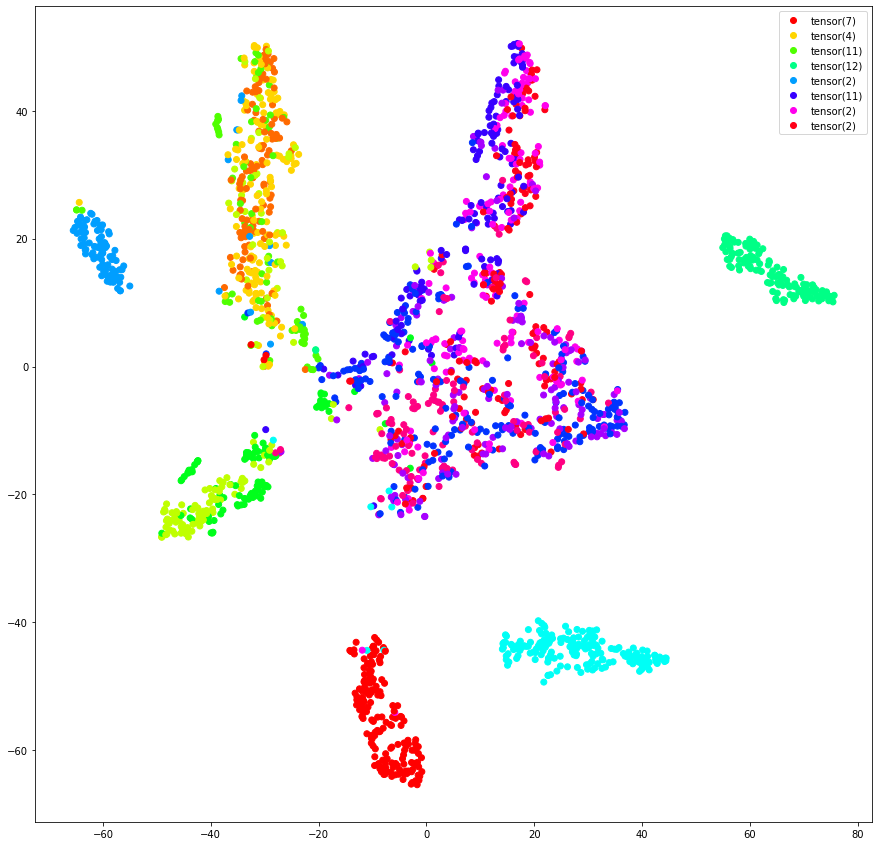

In [43]:
plot_representations(output_tsne_data, labels)

In [33]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

Class: SPEED_LIMIT_80 has samples: 192 
Class: SPEED_LIMIT_60 has samples: 190 
Class: NO_STOPPING_OR_STANDING has samples: 242 
Class: COMPULSARY_KEEP_RIGHT has samples: 223 
Class: GAP_IN_MEDIAN has samples: 180 
Class: CROSS_ROAD has samples: 140 
Class: PEDESTRIAN_CROSSING has samples: 121 
Class: SPEED_LIMIT_50 has samples: 200 
Class: HORN_PROHIBITED has samples: 160 
Class: SPEED_LIMIT_40 has samples: 170 
Class: NO_ENTRY has samples: 174 
Class: HUMP_OR_ROUGH_ROAD has samples: 101 
Class: SPEED_LIMIT_30 has samples: 238 
Class: LEFT_TURN_PROHIBITED has samples: 126 
Class: SPEED_LIMIT_70 has samples: 160 

Total number of samples:  2617

Time taken: 0.018933773040771484


In [34]:
model_savepath = savepath+"alexnetmodel_d1.pt"
results_savepath = savepath+"alexnetmodel_d1_results.pkb"

trained_AlexNet_model, device = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

Epoch [1/10], Step [10/66], Loss: 2.7096, Accuracy: 12.50%, Validation Accuracy: 11.09%
Epoch [1/10], Step [20/66], Loss: 2.6769, Accuracy: 15.62%, Validation Accuracy: 9.18%
Epoch [1/10], Step [30/66], Loss: 2.7108, Accuracy: 3.12%, Validation Accuracy: 5.93%
Epoch [1/10], Step [40/66], Loss: 2.6856, Accuracy: 9.38%, Validation Accuracy: 5.93%
Epoch [1/10], Step [50/66], Loss: 2.6713, Accuracy: 15.62%, Validation Accuracy: 7.07%
Epoch [1/10], Step [60/66], Loss: 2.6669, Accuracy: 3.12%, Validation Accuracy: 7.65%
Epoch [2/10], Step [10/66], Loss: 2.5634, Accuracy: 25.00%, Validation Accuracy: 12.24%
Epoch [2/10], Step [20/66], Loss: 2.6438, Accuracy: 12.50%, Validation Accuracy: 13.38%
Epoch [2/10], Step [30/66], Loss: 2.5841, Accuracy: 9.38%, Validation Accuracy: 10.90%
Epoch [2/10], Step [40/66], Loss: 2.5978, Accuracy: 18.75%, Validation Accuracy: 16.63%
Epoch [2/10], Step [50/66], Loss: 2.5121, Accuracy: 6.25%, Validation Accuracy: 16.06%
Epoch [2/10], Step [60/66], Loss: 2.5908, 

In [ ]:
# for loading model
# trained_AlexNet_model.load_state_dict(torch.load(path+"alexnetmodel.pt"))

In [54]:
while True:
    pass

KeyboardInterrupt: 

In [ ]:
evaluate_model(trained_AlexNet_model, test_loader, device, nclasses)

On dataset 2:

In [45]:
nclasses=12

In [46]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [47]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [48]:
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate) 

In [49]:
path_train = path_dataset2+"train/"
path_test = path_dataset2+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

Device: cuda:0


In [55]:
outputs, labels = get_representations(trained_AlexNet_model, train_loader)

In [56]:
output_tsne_data = get_tsne(outputs)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


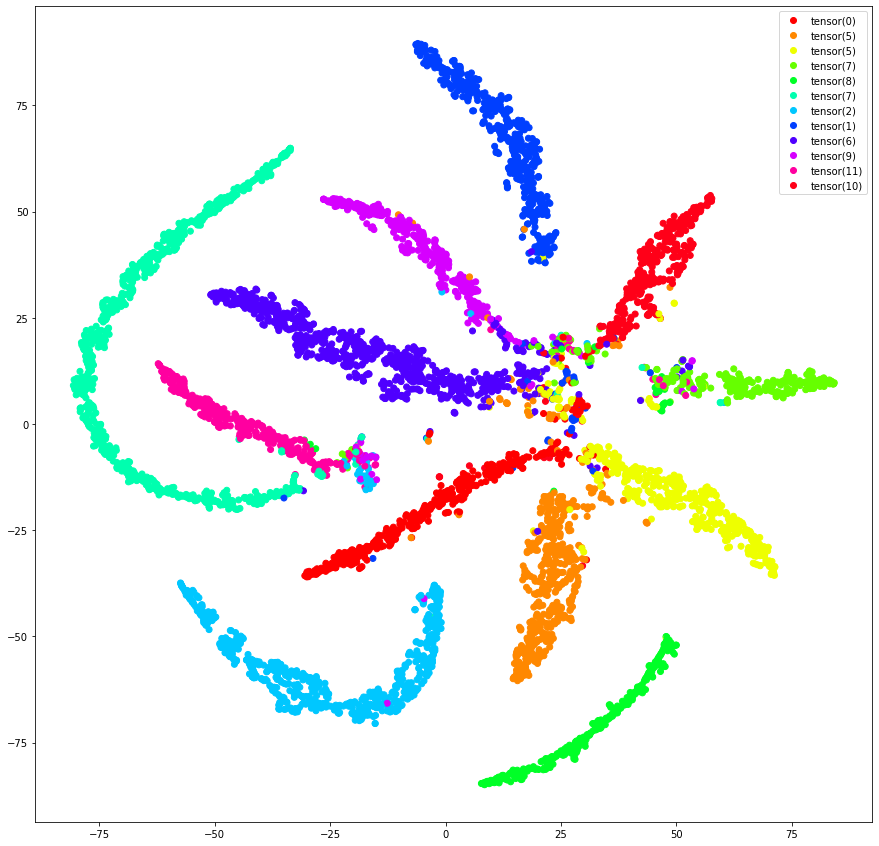

In [57]:
plot_representations(output_tsne_data, labels)

In [52]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

Class: Pedestrain has samples: 1014 
Class: NO Stopping has samples: 1075 
Class: Right Turn Prohibited has samples: 436 
Class: Danger has samples: 399 
Class: Compulsory Keep BothSide has samples: 573 
Class: Maximum Speed 30 has samples: 477 
Class: Right Margin has samples: 506 
Class: Cycle crossing has samples: 662 
Class: Roundabouts has samples: 497 
Class: One way Traffic has samples: 684 
Class: Compulsory Keep Right has samples: 703 
Class: No Entry has samples: 930 

Total number of samples:  7956

Time taken: 0.015614986419677734


In [53]:
model_savepath = savepath+"alexnetmodel_d2.pt"
results_savepath = savepath+"alexnetmodel_d2_results.pkb"

trained_AlexNet_model, device = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

Epoch [1/10], Step [10/199], Loss: 2.4670, Accuracy: 15.62%, Validation Accuracy: 11.57%
Epoch [1/10], Step [20/199], Loss: 2.6431, Accuracy: 3.12%, Validation Accuracy: 12.07%
Epoch [1/10], Step [30/199], Loss: 2.5124, Accuracy: 3.12%, Validation Accuracy: 12.07%
Epoch [1/10], Step [40/199], Loss: 2.3924, Accuracy: 15.62%, Validation Accuracy: 13.64%
Epoch [1/10], Step [50/199], Loss: 2.4904, Accuracy: 12.50%, Validation Accuracy: 13.64%
Epoch [1/10], Step [60/199], Loss: 2.5243, Accuracy: 6.25%, Validation Accuracy: 13.64%
Epoch [1/10], Step [70/199], Loss: 2.4727, Accuracy: 9.38%, Validation Accuracy: 13.64%
Epoch [1/10], Step [80/199], Loss: 2.5010, Accuracy: 9.38%, Validation Accuracy: 13.64%
Epoch [1/10], Step [90/199], Loss: 2.5145, Accuracy: 15.62%, Validation Accuracy: 13.64%
Epoch [1/10], Step [100/199], Loss: 2.4235, Accuracy: 12.50%, Validation Accuracy: 13.64%
Epoch [1/10], Step [110/199], Loss: 2.4532, Accuracy: 15.62%, Validation Accuracy: 13.64%
Epoch [1/10], Step [120/

In [ ]:
# for loading model
# trained_AlexNet_model.load_state_dict(torch.load(path+"alexnetmodel.pt"))

In [ ]:
evaluate_model(trained_AlexNet_model, test_loader, device, nclasses)

In [ ]:
output_tsne_data = get_tsne(outputs)

In [ ]:
plot_representations(output_tsne_data, labels)

On dataset 3:

In [ ]:
nclasses=8

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

In [ ]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset3+"Train/"
path_test = path_dataset3+"Test/"

val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

In [ ]:
outputs, labels = get_representations(AlexNet_model, train_loader)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"alexnetmodel_d3.pt"
results_savepath = savepath+"alexnetmodel_d3_results.pkb"

trained_AlexNet_model, device = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
# for loading model
# trained_AlexNet_model.load_state_dict(torch.load(path+"alexnetmodel.pt"))

In [ ]:
evaluate_model(trained_AlexNet_model, test_loader, device, nclasses)

Architecture 2: VGG-11

on dataset 1:

In [ ]:
nclasses=15

In [ ]:
VGG11_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)

In [ ]:
prev_out = VGG11_model.classifier[3].out_features
VGG11_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
VGG11_model.eval()

In [ ]:
optimizer = torch.optim.Adam(VGG11_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = VGG11_model.to(device)

In [ ]:
outputs, labels = get_representations(VGG11_model, train_loader)

In [ ]:
output_tsne_data = get_tsne(outputs)

In [ ]:
plot_representations(output_tsne_data, labels)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"vgg11model_d1.pt"
results_savepath = savepath+"vgg11model_d1_results.pkb"

trained_VGG11_model, device = train_model(VGG11_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_VGG11_model, test_loader, device, nclasses)

on dataset 2:

In [ ]:
nclasses=12

In [ ]:
VGG11_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)

In [ ]:
prev_out = VGG11_model.classifier[3].out_features
VGG11_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
optimizer = torch.optim.Adam(VGG11_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset2+"train/"
path_test = path_dataset2+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = VGG11_model.to(device)

In [ ]:
outputs, labels = get_representations(VGG11_model, train_loader)

In [ ]:
output_tsne_data = get_tsne(outputs)

In [ ]:
plot_representations(output_tsne_data, labels)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"vgg11model_d2.pt"
results_savepath = savepath+"vgg11model_d2_results.pkb"

trained_VGG11_model, device = train_model(VGG11_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_VGG11_model, test_loader, device, nclasses)

on dataset 3:

In [ ]:
nclasses=8

In [ ]:
VGG11_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)

In [ ]:
prev_out = VGG11_model.classifier[3].out_features
VGG11_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
optimizer = torch.optim.Adam(VGG11_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset3+"Train/"
path_test = path_dataset3+"Test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = VGG11_model.to(device)

In [ ]:
outputs, labels = get_representations(VGG11_model, train_loader)

In [ ]:
output_tsne_data = get_tsne(outputs)

In [ ]:
plot_representations(output_tsne_data, labels)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"vgg11model_d3.pt"
results_savepath = savepath+"vgg11model_d3_results.pkb"

trained_VGG11_model, device = train_model(VGG11_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_VGG11_model, test_loader, device, nclasses)

Architecture 3: ResNet-18

on dataset 1:

In [ ]:
nclasses=15

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
ResNet_model.eval()

In [ ]:
optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = ResNet_model.to(device)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"resnetmodel_d1.pt"
results_savepath = savepath+"resnetmodel_d1_results.pkb"

trained_ResNet_model, device = train_model(ResNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_ResNet_model, test_loader, device, nclasses)

on dataset 2:

In [ ]:
nclasses=12

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset2+"train/"
path_test = path_dataset2+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x= ResNet_model.to(device)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"resnetmodel_d2.pt"
results_savepath = savepath+"resnetmodel_d2_results.pkb"

trained_ResNet_model, device = train_model(ResNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_ResNet_model, test_loader, device, nclasses)

on dataset 3:

In [ ]:
nclasses=8

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset3+"Train/"
path_test = path_dataset3+"Test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = ResNet_model.to(device)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"resnetmodel_d3.pt"
results_savepath = savepath+"resnetmodel_d3_results.pkb"

trained_ResNet_model, device = train_model(ResNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_ResNet_model, test_loader, device, nclasses)

Transfer Learning Models:

Alexnet with dataset 1

In [ ]:
nclasses=15

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

In [ ]:
# layers = AlexNet_model.state_dict().keys()

for name, param in AlexNet_model.named_parameters():
    if name.startswith('features'):
        param.requires_grad = False

In [ ]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
for name, param in AlexNet_model.named_parameters():
        print("Layer: {} has requires_grad set to: {}".format(name, param.requires_grad))

In [ ]:
AlexNet_model.eval()

In [ ]:
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"alexnetmodel_tl_d1.pt"
results_savepath = savepath+"alexnetmodel_tl_d1_results.pkb"

trained_AlexNet_model, device = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_AlexNet_model, test_loader, device, nclasses)

ResNet-18 with dataset 1

nclasses=15

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [ ]:
# layers = ResNet_model.state_dict().keys()

for name, param in ResNet_model.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
for name, param in ResNet_model.named_parameters():
        print("Layer: {} has requires_grad set to: {}".format(name, param.requires_grad))

In [ ]:
ResNet_model.eval()

In [ ]:
optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = ResNet_model.to(device)

In [ ]:
class_weights = get_class_weights(path_train, mappings)

class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

criterion = get_criterion(class_weights)

In [ ]:
model_savepath = savepath+"resnetmodel_tl_d1.pt"
results_savepath = savepath+"resnetmodel_tl_d1_results.pkb"

trained_ResNet_model, device = train_model(ResNet_model, num_epochs, train_loader, criterion, optimizer, model_savepath, results_savepath, device)

In [ ]:
evaluate_model(trained_ResNet_model, test_loader, device, nclasses)